In [54]:
import numpy as np
import matplotlib.pyplot as plt
import stim

## Pauli strings

There are three ways to initialize a Pauli string in stim:
1. From a numpy array
1. From a string of characters
1. From a unitary matrix.

When initializing a Pauli string from a string of characters, the phase is represented by one of `+`, `-`, `i`, and `-i`. The Pauli matrices $X$, $Y$, and $Z$ are respresented by the characters `X`, `Y`, and `Z`. The identity matrix $I$ can be either `I` or `_`.

When initializing from numpy arrays, we use the binary symplectic representation. We pass two arrays representing the $X$ and $Z$ parts. The sign of a Pauli string can be one of `1`, `-1`, `1j`, and `-1j`.

In [ ]:
ps1 = stim.PauliString("-_XYZ")
xs = np.array([0, 1, 1, 0], dtype=np.bool_)
zs = np.array([0, 0, 1, 1], dtype=np.bool_)
ps2 = stim.PauliString.from_numpy(xs=xs, zs=zs, sign=-1)
assert ps1 == ps2

_Problem:_ Build the unitary matrix for the Pauli string $-iX \otimes Y$. Then initialize the stim Pauli string $-iYX$ and check that they are equal. You may want to use the `np.kron` function to take the tensor product of the Pauli matrices.

In [20]:
x = np.array([[0., 1.], [1., 0.]])
y = np.array([[0., -1j], [1j, 0.]])
u = -1j * np.kron(x, y)
ps1 = stim.PauliString.from_unitary_matrix(u)
ps2 = stim.PauliString("-iYX")
assert ps1 == ps2

The Pauli strings in stim support a few operations:
1. Scalar multiplication with `*`. This is to change the phase of the string.
1. Pauli string multiplication with `*`. This is the usual way we mutltiply strings.
1. Tensor products with `+`. Note that this does *not* perform linear combinations!

In [15]:
ps1 = stim.PauliString("-XXX")
ps2 = stim.PauliString("+ZYZ")
print(1j * ps1)
print(ps1 + ps2)
print(ps1 * ps2)

-iXXX
-XXXZYZ
+iYZY


*Problem:* Multiply the Pauli strings $iXY$ and $ZZ$.

*Problem:* Take the tensor product of $X$ and $Y$ and confirm that it is the same as the string $XY$.

## Tableaus and circuits

Clifford unitaries map Pauli strings to other Pauli strings under conjugation. In order to know how a specific Pauli string will transform, we can write it in terms of the generators $\{X_1, \ldots, X_n, Z_1, \ldots, Z_n\}$. A *tableau* encodes how each Pauli generator transforms under conjugation. Consider a CNOT gate controlled by qubit 1 and acting on qubit 2. We represent `CNOT` by the unitary $C_X = \ket{0}\bra{0} \otimes I + \ket{1}\bra{1} \otimes X$. We can represent the action of `CNOT` on each generator with a table:

| $P$ | $C_X^\dagger P C_X$ |
| ----- | ----- |
| $XI$ | $XX$ |
| $ZI$ | $ZI$ |
| $IX$ | $IX$ |
| $IZ$ | $ZZ$ |

A *tableau* is a representation of each conjugated generator. stim specifies a tableau in terms of four blocks: `x2x`, `x2z`, `z2x`, and `z2z`. Each represents the $X$ or $Z$ bits of a string after you conjugate an $X$ or $Z$ generator. For example, the `x2z` matrix gives the $Z$ bits of each conjugated $X$-type generator. For our `CNOT` tableau, the `x2x` matrix is

$\begin{bmatrix}
    1 & 1 \\
    0 & 1 \\
\end{bmatrix}$

Note that each row now represents a generator, and each column represents a qubit.

In [ ]:
x2x = np.array([[1, 1], [0, 1]], dtype=np.bool_)
x2z = np.array([[0, 0], [0, 0]], dtype=np.bool_)
z2x = np.array([[0, 0], [0, 0]], dtype=np.bool_)
z2z = np.array([[1, 0], [1, 1]], dtype=np.bool_)
my_tableau = stim.Tableau.from_numpy(
    x2x=x2x, x2z=x2z, z2x=z2x, z2z=z2z
)
cnot_tableau = stim.Tableau.from_named_gate("CNOT")
assert my_tableau == cnot_tableau

+-xz-xz-
| ++ ++
| XZ _Z
| X_ XZ


We can do operations on tableaus. If a tableau represents some unitary $U$, then the inverse of the tableau represents $U^\dagger$.

In [47]:
tableau = stim.Tableau.from_named_gate("S")
print(tableau)
print(tableau.inverse())

+-xz-
| ++
| YZ
+-xz-
| -+
| YZ


We can also compose the transformations represented by two tableaus. If the tableaus represent unitaries $U$ and $V$, then composition returns a tableau representing $UV$.

In [48]:
tab1 = stim.Tableau.from_named_gate("Z")
tab2 = stim.Tableau.from_named_gate("X")
print(tab1 * tab2)

+-xz-
| --
| XZ


A stim circuit is made up of a sequence of gates. We can add gates to a circuit by passing their names and target qubit(s) to the `Circuit.append` method.

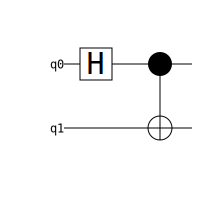

In [38]:
ckt = stim.Circuit()
ckt.append("H", 0)
ckt.append("CNOT", [0, 1])
ckt.diagram('timeline-svg')

Every circuit also has a tableau representation.

In [40]:
tableau = ckt.to_tableau()
print(tableau)

+-xz-xz-
| ++ ++
| ZX _Z
| _X XZ


Since they are Clifford unitaries (at least when there are no measurements), we can conjugate a Pauli string by a Clifford circuit. There are two ways to do this: the `after` and `before` methods of the Pauli string. `after` does the normal conjugation by $U$, and `before` does conjugation by $U^\dagger$.

In [44]:
print(stim.PauliString("XI").after(ckt))
print(stim.PauliString("XI").before(ckt))

+Z_
+ZX


When we add measurements to quantum circuit, we can sample measurement results.

In [49]:
ckt = stim.Circuit()
ckt.append("H", 0)
ckt.append("CNOT", [0, 1])
ckt.append("M", [0, 1])
sampler = ckt.compile_sampler()
samples = sampler.sample(10)
print(samples)

[[ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [False False]
 [False False]
 [ True  True]
 [False False]
 [ True  True]]


## Simulating noise

(array([815.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 185.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

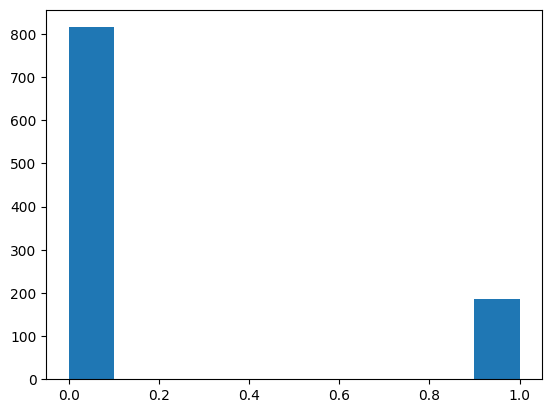

In [57]:
ckt = stim.Circuit()
ckt.append("X_ERROR", 0, arg=0.2)
ckt.append("M", 0)
sampler = ckt.compile_sampler()
samples = sampler.sample(1_000)
plt.hist(samples.astype(int))

## Detector error models and logical observables

Here we will use a GHZ state as an example of detectors.

In [63]:
n = 2
p = 0.1
ckt = stim.Circuit()
ckt.append("H", 0)
targets = []
for i in range(n - 1):
    targets += [i, i+1]
ckt.append("CNOT", targets)
ckt.append("X_ERROR", list(range(n)), arg=p)
ckt.append("M", list(range(n)))
detector_str = "DETECTOR "
for i in range(n):
    detector_str += f"rec[{-i - 1}] "
ckt.append_from_stim_program_text(detector_str)

sampler = ckt.compile_sampler()
m2d_converter = ckt.compile_m2d_converter()
samples = sampler.sample(10)
detection_events = m2d_converter.convert(samples)
print(samples)
print(detection_events)

TypeError: convert(): incompatible function arguments. The following argument types are supported:
    1. (self: stim._stim_polyfill.CompiledMeasurementsToDetectionEventsConverter, *, measurements: object, sweep_bits: object = None, separate_observables: object = None, append_observables: object = None, bit_packed: bool = False, bit_pack_result: bool = False) -> object

Invoked with: stim.CompiledMeasurementsToDetectionEventsConverter(stim.Circuit('''
    H 0
    CX 0 1
    X_ERROR(0.1) 0 1
    M 0 1
    DETECTOR rec[-1] rec[-2]
''')), array([[ True,  True],
       [False, False],
       [False, False],
       [ True,  True],
       [ True,  True],
       [False, False],
       [ True,  True],
       [ True,  True],
       [False, False],
       [ True,  True]])